# Research Question:
### What are the most influential variables on the severity of accidents?

Useful Paper:
    https://www.sciencedirect.com/science/article/pii/S2590198223000611

In [1]:
#Display Spark Output in scrollable format within jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Load Data

In [4]:
#Instantiate Spark Session
spark = (SparkSession
  .builder
  .appName("US_Accidents")
  .getOrCreate())
spark.sparkContext.setLogLevel("ERROR") #supress warnings

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/25 16:05:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Read in Dataset
df = spark.read.parquet("final_dataset_binary.parquet")
df.show(5)

+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+-----------------+
|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|Severity_Binary|Percent_Age_15-24|
+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+-----------------+
|         21|      85|      30|         1|        10|            0|      1|        1|   0|   1|(3

In [6]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 7026806
DataFrame Columns count : 22


# Sampling

In [7]:
# Check Class Imbalance
cts = df.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

+---------------+-------+------------------+
|Severity_Binary|  count|           percent|
+---------------+-------+------------------+
|              1|1302620|18.537867702623352|
|              0|5724186| 81.46213229737664|
+---------------+-------+------------------+



In [8]:
# Undersample each class by 80% of the smallest class
sample = (cts.select("count").rdd.min()[0])*0.8

class0 = sample/(cts.select("count").where(cts.Severity_Binary == '0').rdd.min()[0])
class1 = sample/(cts.select("count").where(cts.Severity_Binary == '1').rdd.min()[0])

# Split Data by Class - Downsampling

# Create a temporary view to use SQL
df.createOrReplaceTempView("data_view")

# Calculate fractions for each class
#fractions = df.groupBy("Severity").count().rdd.map(lambda row: (row[0], 0.8)).collectAsMap() #samples 80% of each class
fractions = {0: class0, 1: class1} #downsample each class to 80% of the smallest class

# Use stratified sampling to maintain class distribution
train_data = df.sampleBy("Severity_Binary", fractions, seed=42)
test_data = df.subtract(train_data)

In [9]:
# Print Overall % Sampled from DF
print(train_data.count()/df.count()*100)

# Print % Sampled for each class within Train Data
train_data.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / train_data.count())*100).show()

29.68448253730073
+---------------+-------+-----------------+
|Severity_Binary|  count|          percent|
+---------------+-------+-----------------+
|              1|1042070| 49.9585065423509|
|              0|1043801|50.04149345764911|
+---------------+-------+-----------------+



In [10]:
# Print Overall % Sampled from DF
print(test_data.count()/df.count()*100)

# Print % Sampled for each class within Train Data
test_data.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / test_data.count())*100).show()

54.53338259231862


+---------------+-------+-----------------+
|Severity_Binary|  count|          percent|
+---------------+-------+-----------------+
|              1| 233338|6.089267749751759|
|              0|3598617|93.91073225024824|
+---------------+-------+-----------------+



# Modeling

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Select all features except target variable
feature_list = []
for col in df.columns:
    if col == 'Severity_Binary':
        continue
    else:
        feature_list.append(col)     
        
# Vectorize Features
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')

In [13]:
# Create a RandomForestClassifier
rf = GBTClassifier(labelCol="Severity_Binary", featuresCol="features")
# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxIter, [3, 4, 7, 10]) \
    .addGrid(rf.maxDepth, [5, 6, 7]) \
    .build()

# Create a CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Severity_Binary"
                                                                      , predictionCol="prediction"
                                                                      , metricName="truePositiveRateByLabel"
                                                                      , metricLabel=1.0),
                          numFolds=5)

# Fit the model
cvModel = crossval.fit(train_data)

# Make predictions on the test set
predictions = cvModel.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction", metricName="truePositiveRateByLabel", metricLabel=1.0)
recall = evaluator.evaluate(predictions)
print("Recall: ", recall)

# Get and save the best model
bestModel = cvModel.bestModel
bestModel.save("best_gbt_model")
print(bestModel.stages[-1]._java_obj.paramMap()) 

#Ran in 20 minutes

Recall:  0.6685580574102804
{
	GBTClassifier_577ff59745aa-featuresCol: features,
	GBTClassifier_577ff59745aa-labelCol: Severity_Binary,
	GBTClassifier_577ff59745aa-maxDepth: 7,
	GBTClassifier_577ff59745aa-maxIter: 3
}


## Load Saved Best Model

In [14]:
# Load the saved best model
loadedCvModel = PipelineModel.load("best_gbt_model")

## Evaluation Metrics

Weighted Precision: 0.9172081024221674
Weighted F1 Score: 0.7584867321533
Accuracy: 0.673250599237204


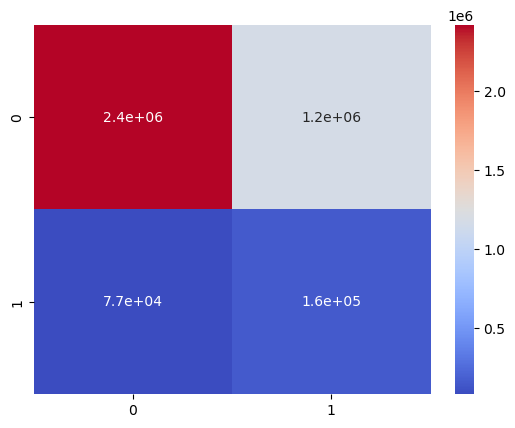

Area Under ROC: 0.6710564629250086


In [15]:
# Further Metrics on Best Model
pred = loadedCvModel.transform(test_data)

#Evaluate (Confusion Matrix, Accuracy, Weighted Precision, Recall, and F1 Score)
predictionAndLabels = pred.select("prediction", "Severity_Binary")
rdd = predictionAndLabels.rdd.map(lambda x: tuple(map(float, x)))
multi_metrics = MulticlassMetrics(rdd)

# Get precision, recall, and F1-score for each class
print(f'Weighted Precision: {multi_metrics.weightedPrecision}') #would expect to be good when test sample has high majority 0 class
#print(f'Weighted Recall: {multi_metrics.weightedRecall}')
print(f'Weighted F1 Score: {multi_metrics.weightedFMeasure()}') #would like to optimize this (balance of precision and recall)
print(f'Accuracy: {multi_metrics.accuracy}') #could be skewed with imbalanced test set

# Plot confusion matrix
cf = multi_metrics.confusionMatrix().toArray()
cf_df = pd.DataFrame(cf, columns=['0', '1'])
sns.heatmap(cf_df, annot=True, cmap="coolwarm")
plt.show()

# AUC Score
binary_metrics = BinaryClassificationMetrics(rdd)
auc = binary_metrics.areaUnderROC
print("Area Under ROC:", auc)

## Feature Importance

In [16]:
feature_importances = cvModel.bestModel.stages[-1].featureImportances

# Create a mapping between feature names and their importance scores
feature_importance_dict = {}
feature_names = assembler.getInputCols()
for i, feature_name in enumerate(feature_names):
    feature_importance_dict[feature_name] = feature_importances[i]

# Sort the feature importance dictionary by score in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature_name, importance_score in sorted_feature_importances:
    print(f"{feature_name}: {importance_score}")

Percent_Age_65_over: 0.3869253739097606
Temperature: 0.11496502687118677
Wind_Speed: 0.0967952228806276
Pressure: 0.08414888863658247
Traffic_Intersection: 0.054582735204807754
SeasonVec: 0.04565781470451271
Percent_Age_15-24: 0.0416667123391889
Astronomical_TwilightIndex: 0.031445598330001476
Traffic_Interference: 0.025492008742653154
Humidity: 0.024152231707066575
Interstate_Indicator: 0.02117547015689948
MedianIncome: 0.013357533080524913
Urban_Ratio: 0.009780774679372372
Weekday: 0.008978982826591424
Sex_ratio: 0.00749945640397082
Destination: 0.005080132881547842
Rush_Hour: 0.0037161319015281656
Rain: 0.0013884745697444625
Visibility: 0.0013836812327231729
Snow: 0.0001243825021023369
Precipitation: 0.0
